In [ ]:
import numpy as np
import pandas as pd
import os
import sys
from laser_core.propertyset import PropertySet
from laser_core.migration import gravity
from laser_core.migration import row_normalizer
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

from laser_generic import Model
from laser_generic import Infection
from laser_generic import Susceptibility
from laser_generic import Exposure
from laser_generic import Transmission
from laser_generic import Births_ConstantPop
from laser_generic.importation import Infect_Random_Agents
from laser_generic.utils import set_initial_susceptibility_in_patch
from laser_generic.utils import seed_infections_in_patch
import pickle


data_dir = os.path.join('..', "data")
sys.path.append(data_dir)

from EnglandWalesmeasles import data as engwal
distances = np.load(os.path.join("..", "data", "EnglandWalesdistances.npy"))

f"{np.__version__=}"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


"np.__version__='1.26.4'"

In [2]:
average_pop = np.array([np.mean(place.population) for place in engwal.places.values()])
average_birthrate = np.array([np.mean(place.births/place.population) for place in engwal.places.values()])
average_cbr = 1000*np.sum(average_pop*average_birthrate)/np.sum(average_pop)

average_cbr

17.190759545084912

In [3]:
#For starters, we will work with a constant population and constant crude birth rate over the network.  
#This may prevent seeing some of the periodicity switch behavior, but we are focused on explicitly spatial stuff for now.
data = [{"name": placename,
         "population": place.population[0],
         "latitude": place.latitude,
         "longitude": place.longitude} for placename, place in engwal.places.items()]

scenario = pd.DataFrame(data)
parameters = PropertySet(
    {"seed": 4, "nticks": 365,
    "exp_shape": 40, "exp_scale": 0.25,
    "verbose": True, "beta": 1.2, "inf_mean": 10, "inf_sigma": 2, "cbr": average_cbr,
    "seasonality_factor": 0.2, "seasonality_phase": 182,
    "importation_period": 30, "importation_count": 3, "importation_start": 1, "importation_end": 8*365}
)

model = Model(scenario, parameters)
model.components = [
    Births_ConstantPop,
    Susceptibility,
    Transmission,
    Exposure,
    Infection,
    Infect_Random_Agents,
]

model.patches.network = gravity(np.array(scenario.population), distances, 1e-6, 0, 1, 2)

mu = (1 + parameters.cbr / 1000) ** (1 / 365) - 1
R0 = parameters.beta / (mu + 1 / parameters.inf_mean)
for i in range(len(model.patches)):
    set_initial_susceptibility_in_patch(model, i, 1 / R0 + 0.02 * np.random.normal())

seed_infections_in_patch(model, ipatch=0, ninfections=3)
model.run()

2025-05-14 11:02:15.560948: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 11:02:21.755511: Running the generic model for 365 ticks…


100%|██████████| 365/365 [00:10<00:00, 34.72it/s]

Completed the generic model at 2025-05-14 11:02:32.294423…
Susceptibility_census:       138,946 µs
Transmission_census  :        17,308 µs
Exposure_census      :        13,120 µs
Infection_census     :       294,432 µs
Model                :         3,822 µs
Births_ConstantPop   :       456,994 µs
Susceptibility       :           724 µs
Transmission         :     9,972,136 µs
Exposure             :     4,186,080 µs
Infection            :     3,760,814 µs
Infect_Random_Agents :     2,074,712 µs
Total:                    20,919,088 microseconds


In [ ]:
# Test equality for cases
#cases_equal = np.array_equal(model.patches.cases, model.patches.cases_test[:-1, :])

# Test equality for susceptibility
#susceptibility_equal = np.array_equal(model.patches.susceptibility, model.patches.susceptibility_test[:-1, :])

# Test equality for recovered
#recovered_equal = np.array_equal(model.patches.recovered, model.patches.recovered_test[:-1, :])

# Test equality for exposed
#exposed_equal = np.array_equal(model.patches.exposed, model.patches.exposed_test[:-1, :])

#cases_equal, susceptibility_equal, recovered_equal, exposed_equal

(True, True, True, True)

In [ ]:
data = [{"name": placename,
         "population": place.population[0],
         "latitude": place.latitude,
         "longitude": place.longitude} for placename, place in engwal.places.items()]
scenario = pd.DataFrame(data)
parameters = PropertySet(
    {"seed": 4, "nticks": 50*365,
    "exp_shape": 40, "exp_scale": 0.25,
    "verbose": True, "beta": 1.2, "inf_mean": 10, "inf_sigma": 2, "cbr": average_cbr,
    "seasonality_factor": 0.2, "seasonality_phase": 182,
    "importation_period": 30, "importation_count": 3, "importation_start": 1, "importation_end": 8*365
    }
)

for k in np.logspace(-8, -4, 30):
    model = Model(scenario, parameters)
    model.components = [
        Births_ConstantPop,
        Susceptibility,
        Transmission,
        Exposure,
        Infection,
        Infect_Random_Agents,
    ]

    model.patches.network = row_normalizer(gravity(np.array(scenario.population), distances, k, 0, 1, 2), 0.5)

    mu = (1 + parameters.cbr / 1000) ** (1 / 365) - 1
    R0 = parameters.beta / (mu + 1 / parameters.inf_mean)
    for i in range(len(model.patches)):
        set_initial_susceptibility_in_patch(model, i, 1 / R0 + 0.02 * np.random.normal())

    seed_infections_in_patch(model, ipatch=0, ninfections=3)
    model.run()
    output_path = os.path.join('..', 'outputs', f"EWoutputs_gravity_{k:.1e}.pkl")
    with open(output_path, "wb") as file:
        pickle.dump(model.patches, file)


2025-05-13 23:01:02.898184: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-13 23:01:11.010602: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [11:21<00:00, 26.79it/s]


Completed the generic model at 2025-05-13 23:12:32.211635…
Susceptibility_census:       668,638 µs
Transmission_census  :       180,992 µs
Exposure_census      :       243,684 µs
Infection_census     :       484,212 µs
Model                :       353,234 µs
Births_ConstantPop   :    18,216,846 µs
Susceptibility       :        33,890 µs
Transmission         :   902,747,018 µs
Exposure             :   235,743,964 µs
Infection            :   197,136,478 µs
Infect_Random_Agents :       150,484 µs
Total:                 1,355,959,440 microseconds
2025-05-13 23:12:32.826558: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-13 23:12:41.292509: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [11:31<00:00, 26.40it/s]


Completed the generic model at 2025-05-13 23:24:12.467884…
Susceptibility_census:       549,678 µs
Transmission_census  :       152,862 µs
Exposure_census      :       212,056 µs
Infection_census     :       449,930 µs
Model                :       185,206 µs
Births_ConstantPop   :    18,958,618 µs
Susceptibility       :        33,816 µs
Transmission         :   918,984,244 µs
Exposure             :   238,869,126 µs
Infection            :   197,107,368 µs
Infect_Random_Agents :       151,420 µs
Total:                 1,375,654,324 microseconds
2025-05-13 23:24:12.900430: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-13 23:24:20.794111: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [16:03<00:00, 18.94it/s]


Completed the generic model at 2025-05-13 23:40:24.325344…
Susceptibility_census:       609,178 µs
Transmission_census  :       181,640 µs
Exposure_census      :       230,444 µs
Infection_census     :       474,898 µs
Model                :       256,146 µs
Births_ConstantPop   :    51,340,294 µs
Susceptibility       :        34,376 µs
Transmission         : 1,054,986,060 µs
Exposure             :   488,070,406 µs
Infection            :   323,715,792 µs
Infect_Random_Agents :       172,332 µs
Total:                 1,920,071,566 microseconds
2025-05-13 23:40:24.770759: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-13 23:40:31.437388: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [17:14<00:00, 17.64it/s]


Completed the generic model at 2025-05-13 23:57:46.173453…
Susceptibility_census:       457,468 µs
Transmission_census  :       213,608 µs
Exposure_census      :       213,668 µs
Infection_census     :       455,854 µs
Model                :       208,158 µs
Births_ConstantPop   :    56,411,510 µs
Susceptibility       :        32,224 µs
Transmission         : 1,151,747,040 µs
Exposure             :   534,616,854 µs
Infection            :   317,878,606 µs
Infect_Random_Agents :       138,320 µs
Total:                 2,062,373,310 microseconds
2025-05-13 23:57:46.572723: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-13 23:57:53.373345: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [17:32<00:00, 17.35it/s]


Completed the generic model at 2025-05-14 00:15:25.377254…
Susceptibility_census:       593,564 µs
Transmission_census  :       174,614 µs
Exposure_census      :       229,470 µs
Infection_census     :       464,578 µs
Model                :       219,152 µs
Births_ConstantPop   :    59,868,188 µs
Susceptibility       :        32,300 µs
Transmission         : 1,155,741,670 µs
Exposure             :   548,440,640 µs
Infection            :   331,311,574 µs
Infect_Random_Agents :       138,532 µs
Total:                 2,097,214,282 microseconds
2025-05-14 00:15:25.879846: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 00:15:33.836739: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [17:55<00:00, 16.97it/s]


Completed the generic model at 2025-05-14 00:33:29.473260…
Susceptibility_census:       478,964 µs
Transmission_census  :       355,436 µs
Exposure_census      :       167,750 µs
Infection_census     :       424,818 µs
Model                :       328,366 µs
Births_ConstantPop   :    63,415,418 µs
Susceptibility       :        31,606 µs
Transmission         : 1,163,475,834 µs
Exposure             :   577,762,394 µs
Infection            :   337,603,318 µs
Infect_Random_Agents :       135,816 µs
Total:                 2,144,179,720 microseconds
2025-05-14 00:33:29.848884: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 00:33:37.437919: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [18:16<00:00, 16.64it/s]


Completed the generic model at 2025-05-14 00:51:54.311226…
Susceptibility_census:       513,494 µs
Transmission_census  :       172,600 µs
Exposure_census      :       203,146 µs
Infection_census     :       446,080 µs
Model                :       188,178 µs
Births_ConstantPop   :    66,644,684 µs
Susceptibility       :        31,326 µs
Transmission         : 1,183,850,834 µs
Exposure             :   582,132,390 µs
Infection            :   352,560,608 µs
Infect_Random_Agents :       135,828 µs
Total:                 2,186,879,168 microseconds
2025-05-14 00:51:54.753524: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 00:52:02.379054: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [17:29<00:00, 17.38it/s]


Completed the generic model at 2025-05-14 01:09:32.319716…
Susceptibility_census:       622,648 µs
Transmission_census  :       260,672 µs
Exposure_census      :       169,562 µs
Infection_census     :       420,804 µs
Model                :       180,554 µs
Births_ConstantPop   :    58,451,968 µs
Susceptibility       :        31,570 µs
Transmission         : 1,156,875,568 µs
Exposure             :   541,827,728 µs
Infection            :   334,111,442 µs
Infect_Random_Agents :       135,724 µs
Total:                 2,093,088,240 microseconds
2025-05-14 01:09:32.746587: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 01:09:40.270655: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [18:00<00:00, 16.88it/s]


Completed the generic model at 2025-05-14 01:27:41.130857…
Susceptibility_census:       442,840 µs
Transmission_census  :       350,976 µs
Exposure_census      :       167,506 µs
Infection_census     :       410,826 µs
Model                :       303,658 µs
Births_ConstantPop   :    63,142,836 µs
Susceptibility       :        31,448 µs
Transmission         : 1,157,036,010 µs
Exposure             :   589,537,288 µs
Infection            :   342,892,702 µs
Infect_Random_Agents :       134,998 µs
Total:                 2,154,451,088 microseconds
2025-05-14 01:27:41.493162: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 01:27:49.300742: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [18:50<00:00, 16.15it/s]


Completed the generic model at 2025-05-14 01:46:39.617900…
Susceptibility_census:       451,400 µs
Transmission_census  :       355,714 µs
Exposure_census      :       189,412 µs
Infection_census     :       421,394 µs
Model                :       308,084 µs
Births_ConstantPop   :    69,617,230 µs
Susceptibility       :        31,942 µs
Transmission         : 1,183,828,030 µs
Exposure             :   623,847,542 µs
Infection            :   374,405,858 µs
Infect_Random_Agents :       139,112 µs
Total:                 2,253,595,718 microseconds
2025-05-14 01:46:40.056640: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 01:46:47.673090: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [18:08<00:00, 16.76it/s]


Completed the generic model at 2025-05-14 02:04:56.323442…
Susceptibility_census:       543,510 µs
Transmission_census  :       174,426 µs
Exposure_census      :       260,464 µs
Infection_census     :       445,766 µs
Model                :       355,960 µs
Births_ConstantPop   :    62,730,362 µs
Susceptibility       :        31,644 µs
Transmission         : 1,189,324,840 µs
Exposure             :   578,751,710 µs
Infection            :   337,354,336 µs
Infect_Random_Agents :       137,506 µs
Total:                 2,170,110,524 microseconds
2025-05-14 02:04:56.686093: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 02:05:04.682980: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [18:07<00:00, 16.78it/s]


Completed the generic model at 2025-05-14 02:23:12.188036…
Susceptibility_census:       448,262 µs
Transmission_census  :       158,574 µs
Exposure_census      :       196,254 µs
Infection_census     :       426,680 µs
Model                :       143,374 µs
Births_ConstantPop   :    66,088,416 µs
Susceptibility       :        31,650 µs
Transmission         : 1,162,975,418 µs
Exposure             :   586,906,754 µs
Infection            :   350,653,036 µs
Infect_Random_Agents :       134,868 µs
Total:                 2,168,163,286 microseconds
2025-05-14 02:23:12.622549: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 02:23:20.703940: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [17:20<00:00, 17.55it/s]


Completed the generic model at 2025-05-14 02:40:40.804787…
Susceptibility_census:       444,256 µs
Transmission_census  :       188,562 µs
Exposure_census      :       173,918 µs
Infection_census     :       448,870 µs
Model                :       364,812 µs
Births_ConstantPop   :    55,487,720 µs
Susceptibility       :        30,894 µs
Transmission         : 1,149,758,824 µs
Exposure             :   543,097,436 µs
Infection            :   323,375,252 µs
Infect_Random_Agents :       134,432 µs
Total:                 2,073,504,976 microseconds
2025-05-14 02:40:41.222025: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 02:40:49.058324: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [18:19<00:00, 16.60it/s]


Completed the generic model at 2025-05-14 02:59:08.685891…
Susceptibility_census:       444,146 µs
Transmission_census  : 172,800,158,890 µs
Exposure_census      :       179,592 µs
Infection_census     :       440,606 µs
Model                :       132,008 µs
Births_ConstantPop   :    66,123,550 µs
Susceptibility       :        31,638 µs
Transmission         : 1,182,662,302 µs
Exposure             :   589,115,136 µs
Infection            :   352,527,020 µs
Infect_Random_Agents :       137,094 µs
Total:                 174,991,951,982 microseconds
2025-05-14 02:59:09.085530: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 02:59:16.646559: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [16:29<00:00, 18.44it/s]


Completed the generic model at 2025-05-14 03:15:46.325532…
Susceptibility_census: 172,800,456,182 µs
Transmission_census  :       175,824 µs
Exposure_census      :       173,242 µs
Infection_census     :       425,624 µs
Model                :       126,500 µs
Births_ConstantPop   :    46,975,740 µs
Susceptibility       :        31,408 µs
Transmission         : 1,125,895,282 µs
Exposure             :   497,482,072 µs
Infection            :   300,749,982 µs
Infect_Random_Agents :       137,544 µs
Total:                 174,772,629,400 microseconds
2025-05-14 03:15:46.759555: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 03:15:53.493722: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [17:41<00:00, 17.19it/s]


Completed the generic model at 2025-05-14 03:33:34.889665…
Susceptibility_census:       464,426 µs
Transmission_census  :       155,968 µs
Exposure_census      :       176,224 µs
Infection_census     :       433,954 µs
Model                :       132,590 µs
Births_ConstantPop   :    58,468,080 µs
Susceptibility       :        31,258 µs
Transmission         : 173,958,168,110 µs
Exposure             :   566,014,858 µs
Infection            :   331,498,350 µs
Infect_Random_Agents :       136,268 µs
Total:                 174,915,680,086 microseconds
2025-05-14 03:33:35.282933: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 03:33:42.833032: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [17:58<00:00, 16.93it/s]


Completed the generic model at 2025-05-14 03:51:40.932361…
Susceptibility_census:       510,458 µs
Transmission_census  :       173,440 µs
Exposure_census      :       198,178 µs
Infection_census     :       446,842 µs
Model                :       166,136 µs
Births_ConstantPop   :    61,926,126 µs
Susceptibility       :        31,720 µs
Transmission         : 1,158,682,302 µs
Exposure             :   573,781,286 µs
Infection            :   353,184,586 µs
Infect_Random_Agents :       138,984 µs
Total:                 2,149,240,058 microseconds
2025-05-14 03:51:41.456085: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 03:51:48.186833: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [17:09<00:00, 17.73it/s]


Completed the generic model at 2025-05-14 04:08:57.543316…
Susceptibility_census:       620,890 µs
Transmission_census  :       163,500 µs
Exposure_census      :       170,812 µs
Infection_census     :       424,418 µs
Model                :       126,424 µs
Births_ConstantPop   :    54,868,102 µs
Susceptibility       :        31,650 µs
Transmission         : 1,150,186,634 µs
Exposure             :   526,913,284 µs
Infection            :   318,262,858 µs
Infect_Random_Agents :       139,136 µs
Total:                 2,051,907,708 microseconds
2025-05-14 04:08:58.013870: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 04:09:05.744150: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [16:56<00:00, 17.95it/s]


Completed the generic model at 2025-05-14 04:26:02.334358…
Susceptibility_census:       477,852 µs
Transmission_census  :       154,916 µs
Exposure_census      :       170,862 µs
Infection_census     :       459,214 µs
Model                :       339,150 µs
Births_ConstantPop   :    54,493,906 µs
Susceptibility       :        31,670 µs
Transmission         : 1,136,245,830 µs
Exposure             :   517,336,142 µs
Infection            :   316,067,948 µs
Infect_Random_Agents :       140,274 µs
Total:                 2,025,917,764 microseconds
2025-05-14 04:26:02.751387: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 04:26:10.494880: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [18:01<00:00, 16.88it/s]


Completed the generic model at 2025-05-14 04:44:11.610049…
Susceptibility_census:       450,342 µs
Transmission_census  :       163,180 µs
Exposure_census      :       183,218 µs
Infection_census     :       448,728 µs
Model                :       133,532 µs
Births_ConstantPop   :    58,471,446 µs
Susceptibility       :        31,398 µs
Transmission         : 1,171,187,126 µs
Exposure             :   579,548,196 µs
Infection            :   344,628,792 µs
Infect_Random_Agents :       137,172 µs
Total:                 2,155,383,130 microseconds
2025-05-14 04:44:12.014547: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 04:44:18.886397: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [18:49<00:00, 16.15it/s]


Completed the generic model at 2025-05-14 05:03:08.847081…
Susceptibility_census:       477,020 µs
Transmission_census  :       157,126 µs
Exposure_census      :       172,050 µs
Infection_census     :       425,552 µs
Model                :       130,370 µs
Births_ConstantPop   :    69,712,294 µs
Susceptibility       :        31,792 µs
Transmission         : 1,207,563,140 µs
Exposure             :   610,552,454 µs
Infection            :   363,197,700 µs
Infect_Random_Agents :       142,876 µs
Total:                 2,252,562,374 microseconds
2025-05-14 05:03:09.228298: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 05:03:16.986811: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [17:33<00:00, 17.32it/s]


Completed the generic model at 2025-05-14 05:20:50.757309…
Susceptibility_census:       442,212 µs
Transmission_census  :       156,378 µs
Exposure_census      :       178,076 µs
Infection_census     :       423,430 µs
Model                :       145,348 µs
Births_ConstantPop   :    57,492,688 µs
Susceptibility       :        31,818 µs
Transmission         : 1,147,774,382 µs
Exposure             :   560,840,444 µs
Infection            :   333,123,886 µs
Infect_Random_Agents :       135,690 µs
Total:                 2,100,744,352 microseconds
2025-05-14 05:20:51.142899: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 05:20:57.893559: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [18:07<00:00, 16.79it/s]


Completed the generic model at 2025-05-14 05:39:05.025666…
Susceptibility_census:       452,422 µs
Transmission_census  :       155,820 µs
Exposure_census      :       180,958 µs
Infection_census     :       429,568 µs
Model                :       138,636 µs
Births_ConstantPop   :    68,181,988 µs
Susceptibility       :        31,394 µs
Transmission         : 173,967,763,506 µs
Exposure             :   579,003,506 µs
Infection            :   350,964,372 µs
Infect_Random_Agents :       137,964 µs
Total:                 174,967,440,134 microseconds
2025-05-14 05:39:05.432641: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 05:39:13.128093: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [18:25<00:00, 16.51it/s]


Completed the generic model at 2025-05-14 05:57:38.677471…
Susceptibility_census:       444,802 µs
Transmission_census  :       156,830 µs
Exposure_census      :       174,222 µs
Infection_census     :       424,334 µs
Model                :       137,686 µs
Births_ConstantPop   :    70,330,508 µs
Susceptibility       :        31,762 µs
Transmission         : 1,156,059,450 µs
Exposure             :   600,404,374 µs
Infection            :   375,459,570 µs
Infect_Random_Agents :       137,834 µs
Total:                 2,203,761,372 microseconds
2025-05-14 05:57:39.113014: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 05:57:46.846483: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [17:38<00:00, 17.24it/s]


Completed the generic model at 2025-05-14 06:15:25.675898…
Susceptibility_census:       441,388 µs
Transmission_census  :       179,642 µs
Exposure_census      :       178,078 µs
Infection_census     :       445,568 µs
Model                :       146,058 µs
Births_ConstantPop   :    61,343,512 µs
Susceptibility       :        30,118 µs
Transmission         : 1,152,503,334 µs
Exposure             :   556,695,416 µs
Infection            :   338,826,740 µs
Infect_Random_Agents :       136,376 µs
Total:                 2,110,926,230 microseconds
2025-05-14 06:15:26.080973: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 06:15:32.891524: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [17:54<00:00, 16.99it/s]


Completed the generic model at 2025-05-14 06:33:27.080552…
Susceptibility_census:       455,360 µs
Transmission_census  :       153,150 µs
Exposure_census      :       175,058 µs
Infection_census     :       419,952 µs
Model                :       133,022 µs
Births_ConstantPop   :    60,519,274 µs
Susceptibility       :        31,714 µs
Transmission         : 1,165,850,662 µs
Exposure             :   572,390,842 µs
Infection            :   340,912,962 µs
Infect_Random_Agents :       138,422 µs
Total:                 2,141,180,418 microseconds
2025-05-14 06:33:27.472846: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 06:33:35.151643: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [18:10<00:00, 16.74it/s]


Completed the generic model at 2025-05-14 06:51:45.261264…
Susceptibility_census:       444,492 µs
Transmission_census  :       155,088 µs
Exposure_census      :       189,518 µs
Infection_census     :       443,768 µs
Model                :       131,062 µs
Births_ConstantPop   :    62,692,286 µs
Susceptibility       :        31,692 µs
Transmission         : 1,187,087,536 µs
Exposure             :   578,709,952 µs
Infection            :   343,273,724 µs
Infect_Random_Agents :       139,266 µs
Total:                 2,173,298,384 microseconds
2025-05-14 06:51:45.643120: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 06:51:52.301522: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [15:22<00:00, 19.78it/s]


Completed the generic model at 2025-05-14 07:07:14.904647…
Susceptibility_census:       445,042 µs
Transmission_census  :       178,980 µs
Exposure_census      :       174,446 µs
Infection_census     :       427,238 µs
Model                :       297,002 µs
Births_ConstantPop   :    39,190,920 µs
Susceptibility       :        31,354 µs
Transmission         : 1,124,072,778 µs
Exposure             :   409,786,334 µs
Infection            :   263,850,468 µs
Infect_Random_Agents :       138,946 µs
Total:                 1,838,593,508 microseconds
2025-05-14 07:07:15.315382: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 07:07:23.138437: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [18:22<00:00, 16.55it/s]


Completed the generic model at 2025-05-14 07:25:45.532969…
Susceptibility_census:       456,526 µs
Transmission_census  :       158,902 µs
Exposure_census      :       182,010 µs
Infection_census     :       449,900 µs
Model                :       140,722 µs
Births_ConstantPop   :    60,163,884 µs
Susceptibility       :        31,514 µs
Transmission         : 1,176,881,614 µs
Exposure             :   606,161,154 µs
Infection            :   352,653,486 µs
Infect_Random_Agents :       137,802 µs
Total:                 2,197,417,514 microseconds
2025-05-14 07:25:45.938522: Creating the generic model…
Initializing the generic model with 954 patches…
2025-05-14 07:25:52.597680: Running the generic model for 18250 ticks…


100%|██████████| 18250/18250 [16:44<00:00, 18.16it/s]


Completed the generic model at 2025-05-14 07:42:37.294772…
Susceptibility_census:       661,120 µs
Transmission_census  :       148,846 µs
Exposure_census      :       229,900 µs
Infection_census     :       421,126 µs
Model                :       328,852 µs
Births_ConstantPop   :    49,605,114 µs
Susceptibility       :        32,290 µs
Transmission         : 1,145,173,110 µs
Exposure             :   504,039,218 µs
Infection            :   301,821,928 µs
Infect_Random_Agents :       140,602 µs
Total:                 2,002,602,106 microseconds


In [6]:
np.logspace(-9, -5, 30)

array([1.00000000e-09, 1.37382380e-09, 1.88739182e-09, 2.59294380e-09,
       3.56224789e-09, 4.89390092e-09, 6.72335754e-09, 9.23670857e-09,
       1.26896100e-08, 1.74332882e-08, 2.39502662e-08, 3.29034456e-08,
       4.52035366e-08, 6.21016942e-08, 8.53167852e-08, 1.17210230e-07,
       1.61026203e-07, 2.21221629e-07, 3.03919538e-07, 4.17531894e-07,
       5.73615251e-07, 7.88046282e-07, 1.08263673e-06, 1.48735211e-06,
       2.04335972e-06, 2.80721620e-06, 3.85662042e-06, 5.29831691e-06,
       7.27895384e-06, 1.00000000e-05])

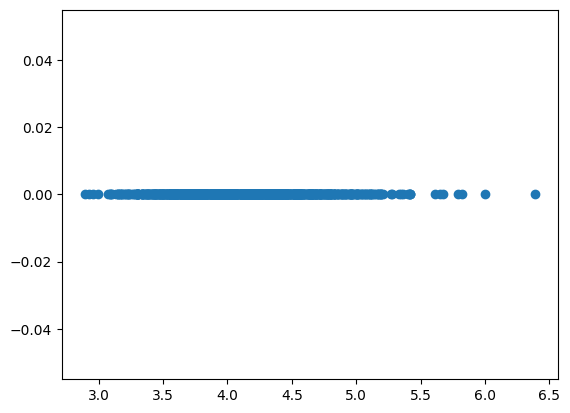

In [9]:
plt.plot(np.log10(model.patches.populations[0,:]), np.sum(model.patches.incidence[3650:,:]==0, axis=0), 'o')

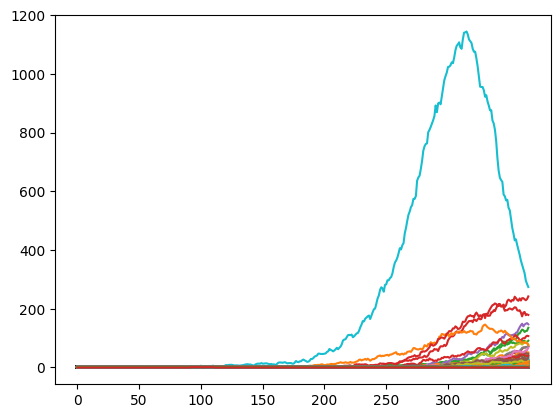

In [4]:
plt.plot(model.patches.cases_test)

In [17]:
(np.where(model.population.susceptibility == 0))[0]

array([       0,        1,        2, ..., 30182535, 30182536, 30182537])

TypeError: only integer scalar arrays can be converted to a scalar index